In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)
batch_size = 256
g_dim = 100

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 2, 2, 1], padding = 'SAME')
def deconv2d(x, W, output_shape):
    return tf.nn.conv2d_transpose(x, W, output_shape, strides = [1, 2, 2, 1], padding = 'SAME')

class layer:
    def __init__(self, in_size, out_size):
#         self.W = tf.Variable(tf.zeros([in_size, out_size]))
        self.W = tf.Variable(tf.random_normal([in_size, out_size], mean=0.0, stddev=0.01))
#         self.b = tf.Variable(tf.zeros([1,out_size]))
#         self.b = tf.Variable(tf.constant(0.1, shape=[1,out_size]))
        self.b = tf.Variable(tf.random_normal([1, out_size], mean=0.0, stddev=0.01))
    
        
    def output(self, inputs, activation_function=None):
        if activation_function == None:
            return tf.matmul(inputs, self.W) + self.b
        else :
            return activation_function(tf.matmul(inputs, self.W) + self.b)
        
def weight_variable(shape):
    '''Helper function to create a weight variable initialized with
    a normal distribution

    Parameters
    ----------
    shape : list
        Size of weight variable
    '''
    initial = tf.random_normal(shape, mean=0.0, stddev=0.01)
    return tf.Variable(initial)

def bias_variable(shape):
    '''Helper function to create a bias variable initialized with
    a constant value.

    Parameters
    ----------
    shape : list
        Size of weight variable
    '''
    initial = tf.random_normal(shape, mean=0.0, stddev=0.01)
    return tf.Variable(initial)

In [4]:
x_d = tf.placeholder(tf.float32, shape = [None, 784])
x_g = tf.placeholder(tf.float32, shape = [None, g_dim])

In [5]:
# d_l1 = layer(784, g_dim)
# d_l2 = layer(g_dim, 1)
# d_l3 = layer(g_dim, 1)

# g_l1 = layer(g_dim, 256)
# g_l2 = layer(256, 784)

# var_d = [d_l1.W, d_l1.b, d_l2.W, d_l2.b]
# var_g = [g_l1.W, g_l1.b, g_l2.W, g_l2.b]


weights = {
    "w_d1" : weight_variable([5, 5, 1, 32]),
    "w_d2" : weight_variable([5, 5, 32, 64]),
    "w_d3" : weight_variable([7 * 7 * 64, 1]),
    
    "w_g1" : weight_variable([g_dim, 4 * 4 * 64]),
    "w_g2" : weight_variable([5, 5, 32, 64]),
    "w_g3" : weight_variable([5, 5, 16, 32]),
    "w_g4" : weight_variable([5, 5, 1, 16])
}

biases = {
    "b_d1" : bias_variable([32]),
    "b_d2" : bias_variable([64]),
    "b_d3" : bias_variable([1]),
    "b_g1" : bias_variable([4 * 4 * 64]),
    "b_g2" : bias_variable([32]),
    "b_g3" : bias_variable([16]),
    "b_g4" : bias_variable([1]),
}

var_d = [weights["w_d1"], weights["w_d2"], weights["w_d3"], biases["b_d1"], biases["b_d2"], biases["b_d3"]]
var_g = [weights["w_g1"], weights["w_g2"],weights["w_g3"], weights["w_g4"], biases["b_g1"], biases["b_g2"],biases["b_g3"], biases["b_g4"]]

In [6]:
def generator(z):
    #100 x 1
    h_g1 = tf.nn.relu(tf.add(tf.matmul(z, weights["w_g1"]), biases["b_g1"]))
    #-1 x 4*4*128
    h_g1_reshape = tf.reshape(h_g1, [-1, 4, 4, 64])
    
    output_shape_g2 = tf.stack([tf.shape(z)[0], 7, 7, 32])
    h_g2 = tf.nn.relu(tf.add(deconv2d(h_g1_reshape, weights["w_g2"], output_shape_g2), biases["b_g2"]))
    
    output_shape_g3 = tf.stack([tf.shape(z)[0], 14, 14, 16])
    h_g3 = tf.nn.relu(tf.add(deconv2d(h_g2, weights["w_g3"], output_shape_g3), biases["b_g3"]))
    
    output_shape_g4 = tf.stack([tf.shape(z)[0], 28, 28, 1])
    h_g4 = tf.nn.tanh(tf.add(deconv2d(h_g3, weights["w_g4"], output_shape_g4), biases["b_g4"]))
    
    return h_g4


def discriminator(x):
    x_reshape = tf.reshape(x, [-1, 28, 28, 1])
    # 28 x 28 x 1
    h_d1 = tf.nn.relu(tf.add(conv2d(x_reshape, weights["w_d1"]), biases["b_d1"]))
    # 14 x 14 x 32
    h_d2 = tf.nn.relu(tf.add(conv2d(h_d1, weights["w_d2"]), biases["b_d2"]))
    # 7 x 7 x 64
    h_d2_reshape = tf.reshape(h_d2, [-1, 7 * 7 * 64])
    h_d3 = tf.nn.sigmoid(tf.add(tf.matmul(h_d2_reshape, weights["w_d3"]), biases["b_d3"]))
    return h_d3

In [17]:
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

g_sample = generator(x_g)
d_real= discriminator(x_d)
d_fake = discriminator(g_sample)

d_loss = -tf.reduce_mean(tf.log(d_real) + tf.log(1. - d_fake))
g_loss = -tf.reduce_mean(tf.log(d_fake))

# 只更新 discriminator
d_optimizer = tf.train.AdamOptimizer(0.00001).minimize(d_loss, var_list= var_d)
# 只更新 generator parameters
g_optimizer = tf.train.AdamOptimizer(0.00001).minimize(g_loss, var_list= var_g)


step: 0  d-loss: 1.38645  g-loss: 0.694792
step: 1000  d-loss: 0.468504  g-loss: 1.31588
step: 2000  d-loss: 0.625756  g-loss: 1.50392
step: 3000  d-loss: 0.318683  g-loss: 1.76542
step: 4000  d-loss: 0.071247  g-loss: 2.71377
step: 5000  d-loss: 0.17841  g-loss: 3.4811
step: 6000  d-loss: 0.15746  g-loss: 2.60846
step: 7000  d-loss: 0.180091  g-loss: 3.08804
step: 8000  d-loss: 0.19412  g-loss: 2.53147
step: 9000  d-loss: 0.0845056  g-loss: 3.32899
step: 10000  d-loss: 0.122555  g-loss: 2.92867
step: 11000  d-loss: 0.191838  g-loss: 2.55565
step: 12000  d-loss: 0.124334  g-loss: 3.16262
step: 13000  d-loss: 0.114716  g-loss: 3.57476
step: 14000  d-loss: 0.117  g-loss: 3.73433
step: 15000  d-loss: 0.0801024  g-loss: 3.65032
step: 16000  d-loss: 0.196603  g-loss: 3.52192
step: 17000  d-loss: 0.105334  g-loss: 3.34003
step: 18000  d-loss: 0.0805028  g-loss: 3.72501
step: 19000  d-loss: 0.0547233  g-loss: 4.05792
step: 20000  d-loss: 0.0625897  g-loss: 4.30478


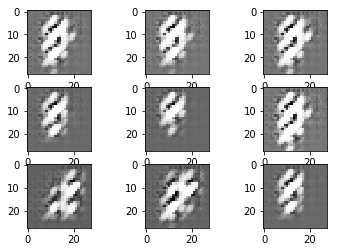

In [18]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

for step in range(20001):
    batch_x = mnist.train.next_batch(batch_size)[0]
#     _, d_loss_train = sess.run([d_optimizer, d_loss], feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
    sess.run(d_optimizer, feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#     _, g_loss_train = sess.run([g_optimizer, g_loss], feed_dict={x_g: sample_Z(batch_size, g_dim)})
    sess.run(g_optimizer, feed_dict={x_g: sample_Z(batch_size, g_dim)})
    if step%1000==0:
        d_loss_train, g_loss_train = sess.run([d_loss, g_loss], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train

zz = sample_Z(batch_size, g_dim)
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(g_sample, feed_dict = {x_g: sample_Z(batch_size, g_dim)})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')


step: 0  d-loss: 0.108541  g-loss: 4.2263
step: 1000  d-loss: 0.0725948  g-loss: 3.76987
step: 2000  d-loss: 0.0935134  g-loss: 3.76774
step: 3000  d-loss: 0.0920741  g-loss: 3.73034
step: 4000  d-loss: 0.0935873  g-loss: 4.28339
step: 5000  d-loss: 0.0702997  g-loss: 4.09313
step: 6000  d-loss: 0.0528974  g-loss: 3.85007
step: 7000  d-loss: 0.0611064  g-loss: 4.13807
step: 8000  d-loss: 0.138661  g-loss: 3.85902
step: 9000  d-loss: 0.107218  g-loss: 4.07691
step: 10000  d-loss: 0.0554305  g-loss: 4.13361
step: 11000  d-loss: 0.0931106  g-loss: 3.95052
step: 12000  d-loss: 0.0584865  g-loss: 3.98683
step: 13000  d-loss: 0.0761393  g-loss: 3.69827
step: 14000  d-loss: 0.138728  g-loss: 3.4302
step: 15000  d-loss: 0.0745806  g-loss: 4.04151
step: 16000  d-loss: 0.0596563  g-loss: 3.89252
step: 17000  d-loss: 0.0663369  g-loss: 4.22603
step: 18000  d-loss: 0.0488293  g-loss: 3.94195
step: 19000  d-loss: 0.0840555  g-loss: 3.81757
step: 20000  d-loss: 0.0788358  g-loss: 3.83088


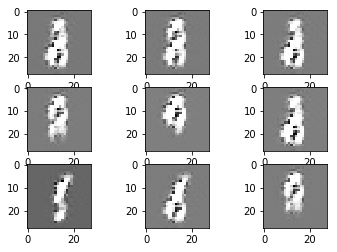

In [19]:
for step in range(20001):
    batch_x = mnist.train.next_batch(batch_size)[0]
#     _, d_loss_train = sess.run([d_optimizer, d_loss], feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
    sess.run(d_optimizer, feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#     _, g_loss_train = sess.run([g_optimizer, g_loss], feed_dict={x_g: sample_Z(batch_size, g_dim)})
    sess.run(g_optimizer, feed_dict={x_g: sample_Z(batch_size, g_dim)})
    if step%1000==0:
        d_loss_train, g_loss_train = sess.run([d_loss, g_loss], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train

# zz = sample_Z(batch_size, g_dim)
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(g_sample, feed_dict = {x_g: sample_Z(batch_size, g_dim)})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')

step: 0  d-loss: 0.0613023  g-loss: 3.89988
step: 1000  d-loss: 0.0848583  g-loss: 3.8178
step: 2000  d-loss: 0.079053  g-loss: 3.70737
step: 3000  d-loss: 0.0957595  g-loss: 3.80967
step: 4000  d-loss: 0.0759879  g-loss: 3.77922
step: 5000  d-loss: 0.0753636  g-loss: 4.13467
step: 6000  d-loss: 0.104136  g-loss: 3.55952
step: 7000  d-loss: 0.0634746  g-loss: 3.90299
step: 8000  d-loss: 0.06339  g-loss: 3.91969
step: 9000  d-loss: 0.119237  g-loss: 3.76953
step: 10000  d-loss: 0.0571369  g-loss: 3.94535
step: 11000  d-loss: 0.0689168  g-loss: 3.65334
step: 12000  d-loss: 0.0856979  g-loss: 3.89189
step: 13000  d-loss: 0.107348  g-loss: 3.7025
step: 14000  d-loss: 0.118448  g-loss: 3.47858
step: 15000  d-loss: 0.102133  g-loss: 3.65692
step: 16000  d-loss: 0.173946  g-loss: 3.58342
step: 17000  d-loss: 0.135609  g-loss: 3.62264
step: 18000  d-loss: 0.126782  g-loss: 3.34682
step: 19000  d-loss: 0.0851174  g-loss: 3.41903
step: 20000  d-loss: 0.098629  g-loss: 3.61064
step: 21000  d-loss

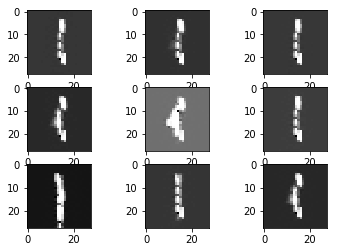

In [20]:
for step in range(100001):
    batch_x = mnist.train.next_batch(batch_size)[0]
#     _, d_loss_train = sess.run([d_optimizer, d_loss], feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
    sess.run(d_optimizer, feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#     _, g_loss_train = sess.run([g_optimizer, g_loss], feed_dict={x_g: sample_Z(batch_size, g_dim)})
    sess.run(g_optimizer, feed_dict={x_g: sample_Z(batch_size, g_dim)})
    if step%1000==0:
        d_loss_train, g_loss_train = sess.run([d_loss, g_loss], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train

# zz = sample_Z(batch_size, g_dim)
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(g_sample, feed_dict = {x_g: sample_Z(batch_size, g_dim)})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')

step: 0  d-loss: 0.0651151  g-loss: 4.36209
step: 1000  d-loss: 0.0304308  g-loss: 4.42282
step: 2000  d-loss: 0.0306007  g-loss: 4.22416
step: 3000  d-loss: 0.125707  g-loss: 4.35759
step: 4000  d-loss: 0.0292838  g-loss: 4.80935
step: 5000  d-loss: 0.0802077  g-loss: 4.5101
step: 6000  d-loss: 0.0699728  g-loss: 4.24772
step: 7000  d-loss: 0.10171  g-loss: 3.80868
step: 8000  d-loss: 0.124324  g-loss: 3.85416
step: 9000  d-loss: 0.100555  g-loss: 3.92421
step: 10000  d-loss: 0.05422  g-loss: 3.84427
step: 11000  d-loss: 0.0622487  g-loss: 4.19493
step: 12000  d-loss: 0.0387862  g-loss: 4.42497
step: 13000  d-loss: 0.0659327  g-loss: 3.91113
step: 14000  d-loss: 0.125393  g-loss: 3.80247
step: 15000  d-loss: 0.0637187  g-loss: 4.18281
step: 16000  d-loss: 0.129853  g-loss: 4.15376
step: 17000  d-loss: 0.122051  g-loss: 4.27146
step: 18000  d-loss: 0.0463155  g-loss: 3.97595
step: 19000  d-loss: 0.0768813  g-loss: 4.05855
step: 20000  d-loss: 0.0960586  g-loss: 4.00896
step: 21000  d-l

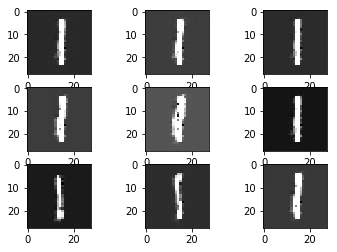

In [21]:
for step in range(30001):
    batch_x = mnist.train.next_batch(batch_size)[0]
#     _, d_loss_train = sess.run([d_optimizer, d_loss], feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
    sess.run(d_optimizer, feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#     _, g_loss_train = sess.run([g_optimizer, g_loss], feed_dict={x_g: sample_Z(batch_size, g_dim)})
    sess.run(g_optimizer, feed_dict={x_g: sample_Z(batch_size, g_dim)})
    if step%1000==0:
        d_loss_train, g_loss_train = sess.run([d_loss, g_loss], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train

# zz = sample_Z(batch_size, g_dim)
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(g_sample, feed_dict = {x_g: sample_Z(batch_size, g_dim)})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')

step: 0  d-loss: 0.0994142  g-loss: 3.9216
step: 1000  d-loss: 0.0925164  g-loss: 4.18952
step: 2000  d-loss: 0.040922  g-loss: 4.04006
step: 3000  d-loss: 0.0515059  g-loss: 4.05547
step: 4000  d-loss: 0.0370605  g-loss: 4.09413
step: 5000  d-loss: 0.109829  g-loss: 4.35378
step: 6000  d-loss: 0.0833332  g-loss: 3.92529
step: 7000  d-loss: 0.0654  g-loss: 4.33159
step: 8000  d-loss: 0.0835302  g-loss: 4.47045
step: 9000  d-loss: 0.0740782  g-loss: 3.47385
step: 10000  d-loss: 0.0647099  g-loss: 4.33362
step: 11000  d-loss: 0.126959  g-loss: 3.86432
step: 12000  d-loss: 0.0800551  g-loss: 4.08515
step: 13000  d-loss: 0.0917487  g-loss: 3.82232
step: 14000  d-loss: 0.0712216  g-loss: 4.02845
step: 15000  d-loss: 0.107803  g-loss: 4.00695
step: 16000  d-loss: 0.073175  g-loss: 4.22156
step: 17000  d-loss: 0.0831089  g-loss: 4.59877
step: 18000  d-loss: 0.0745148  g-loss: 4.31249
step: 19000  d-loss: 0.109094  g-loss: 4.00691
step: 20000  d-loss: 0.0702343  g-loss: 4.03346
step: 21000  d-

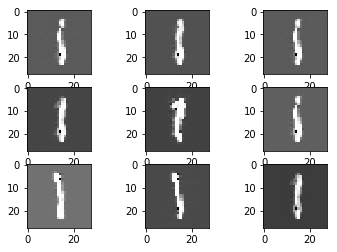

In [22]:
for step in range(30001):
    batch_x = mnist.train.next_batch(batch_size)[0]
#     _, d_loss_train = sess.run([d_optimizer, d_loss], feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
    sess.run(d_optimizer, feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#     _, g_loss_train = sess.run([g_optimizer, g_loss], feed_dict={x_g: sample_Z(batch_size, g_dim)})
    sess.run(g_optimizer, feed_dict={x_g: sample_Z(batch_size, g_dim)})
    if step%1000==0:
        d_loss_train, g_loss_train = sess.run([d_loss, g_loss], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train

# zz = sample_Z(batch_size, g_dim)
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(g_sample, feed_dict = {x_g: sample_Z(batch_size, g_dim)})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')

step: 0  d-loss: 0.087572  g-loss: 4.29509
step: 1000  d-loss: 0.0345719  g-loss: 4.26346
step: 2000  d-loss: 0.0398793  g-loss: 4.1462
step: 3000  d-loss: 0.0552988  g-loss: 4.42831
step: 4000  d-loss: 0.0756199  g-loss: 4.34833
step: 5000  d-loss: 0.0449228  g-loss: 5.7399
step: 6000  d-loss: 0.00570509  g-loss: 6.91358
step: 7000  d-loss: 0.0164167  g-loss: 6.47334
step: 8000  d-loss: 0.0113083  g-loss: 6.39275
step: 9000  d-loss: 0.00332021  g-loss: 6.49785
step: 10000  d-loss: 0.0149255  g-loss: 6.97596
step: 11000  d-loss: 0.0405028  g-loss: 5.56257
step: 12000  d-loss: 0.053746  g-loss: 4.97085
step: 13000  d-loss: 0.052267  g-loss: 5.74274
step: 14000  d-loss: 0.0289243  g-loss: 5.49849
step: 15000  d-loss: 0.0365309  g-loss: 5.15188
step: 16000  d-loss: 0.0327876  g-loss: 5.86041
step: 17000  d-loss: 0.0274843  g-loss: 5.15085
step: 18000  d-loss: 0.0264093  g-loss: 5.08312
step: 19000  d-loss: 0.0748322  g-loss: 4.39072
step: 20000  d-loss: 0.0233844  g-loss: 4.69934
step: 21

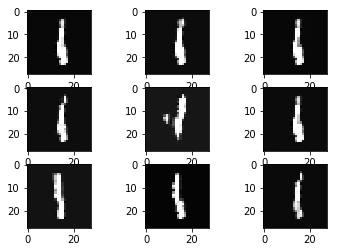

In [23]:
for step in range(30001):
    batch_x = mnist.train.next_batch(batch_size)[0]
#     _, d_loss_train = sess.run([d_optimizer, d_loss], feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
    sess.run(d_optimizer, feed_dict={x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
#     _, g_loss_train = sess.run([g_optimizer, g_loss], feed_dict={x_g: sample_Z(batch_size, g_dim)})
    sess.run(g_optimizer, feed_dict={x_g: sample_Z(batch_size, g_dim)})
    if step%1000==0:
        d_loss_train, g_loss_train = sess.run([d_loss, g_loss], feed_dict=
                            {x_d: batch_x, x_g: sample_Z(batch_size, g_dim)})
        print 'step:', step, ' d-loss:', d_loss_train, ' g-loss:', g_loss_train

# zz = sample_Z(batch_size, g_dim)
gg = sess.run(g_sample, feed_dict = {x_g: zz})
# gg = sess.run(g_sample, feed_dict = {x_g: sample_Z(batch_size, g_dim)})
gg_pic = np.array([np.reshape(m,(28,28)) for m in gg])
fig, ax = plt.subplots(nrows=3, ncols=3)
for i,row in enumerate(ax):
    for j,col in enumerate(row):
        ax[i][j].imshow(gg_pic[i*3+j], cmap='gray')